# GNN Explainability

## BA-Shapes

In [1]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 13.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=c2fd25e687fe29be2f1476879d134fb42b773c056e8a28cb39f8710fd0f32e33
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [2]:
from torch_geometric.datasets import ExplainerDataset
from torch_geometric.datasets.graph_generator import BAGraph
import torch_geometric.transforms as T

dataset = ExplainerDataset(
    graph_generator=BAGraph(num_nodes=300, num_edges=5),
    motif_generator='house',
    num_motifs=80,
    transform=T.Constant(),
)

data = dataset[0]
data

Explanation(edge_index=[2, 3966], y=[700], edge_mask=[3966], node_mask=[700], x=[700, 1])

## BA 2 Motifs

In [3]:
import torch
from torch_geometric.datasets import ExplainerDataset
from torch_geometric.datasets.graph_generator import BAGraph
from torch_geometric.datasets.motif_generator import HouseMotif
from torch_geometric.datasets.motif_generator import CycleMotif

dataset1 = ExplainerDataset(
    graph_generator=BAGraph(num_nodes=25, num_edges=1),
    motif_generator=HouseMotif(),
    num_motifs=1,
    num_graphs=1,
)

dataset2 = ExplainerDataset(
    graph_generator=BAGraph(num_nodes=25, num_edges=1),
    motif_generator=CycleMotif(5),
    num_motifs=1,
    num_graphs=1,
    transform=T.Constant(),
)

dataset = torch.utils.data.ConcatDataset([dataset1, dataset2])
data1 = dataset[0]
data2 = dataset[1]
data2

Explanation(edge_index=[2, 60], edge_mask=[60], node_mask=[30], x=[30, 1])

In [5]:
import torch
from torch_geometric.datasets import BA2MotifDataset

dataset = BA2MotifDataset(root='data/BA2MotifDataset')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: BA2MotifDataset(1000):
Number of graphs: 1000
Number of features: 10
Number of classes: 2

Data(x=[25, 10], edge_index=[2, 50], y=[1])
Number of nodes: 25
Number of edges: 50
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Processing...
Done!


In [6]:
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader

data_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
loaded_data = next(iter(data_loader))

In [7]:
train_dataset, test_dataset = train_test_split(dataset, train_size=0.8, stratify=loaded_data.y)

In [ ]:
from torch_geometric.loader import DataLoader

batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

In [9]:
next(iter(train_loader))

DataBatch(x=[100, 10], edge_index=[2, 200], y=[4], batch=[100], ptr=[5])

In [10]:
dataset[900].edge_index

tensor([[ 0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  3,  4,  4,
          4,  5,  6,  6,  7,  7,  7,  8,  9, 10, 11, 11, 12, 13, 13, 14, 15, 16,
         17, 18, 19, 20, 20, 20, 20, 21, 21, 21, 22, 22, 23, 23, 24, 24],
        [ 1,  6, 13, 20,  0,  2,  3,  4,  7,  9, 10, 12, 17, 19,  1,  1,  1,  5,
         16,  4,  0, 14,  1,  8, 11,  7,  1,  1,  7, 15,  1,  0, 18,  6, 11,  4,
          1, 13,  1,  0, 21, 23, 24, 20, 22, 24, 21, 23, 20, 22, 20, 21]])

## Graph Convolutional Network

In [11]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        #x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(10, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
from tqdm.notebook import tqdm

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in tqdm(train_loader):  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 100):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

## Graph isomorphism Network

### Torch geometric

In [ ]:
!pip install torch_geometric

### Import BA2MotifDataset

In [12]:
import torch
from torch_geometric.datasets import BA2MotifDataset

dataset = BA2MotifDataset(root='data/BA2MotifDataset')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: BA2MotifDataset(1000):
Number of graphs: 1000
Number of features: 10
Number of classes: 2

Data(x=[25, 10], edge_index=[2, 50], y=[1])
Number of nodes: 25
Number of edges: 50
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


### Visualization

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

In [14]:
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def visualize(data):
    G = to_networkx(data, to_undirected=True)

    # 3D spring layout
    pos = nx.spring_layout(G, dim=3, seed=0)

    # Extract node and edge positions from the layout
    node_xyz = np.array([pos[v] for v in sorted(G)])
    edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

    # Create the 3D figure
    fig = plt.figure(figsize=(16,16))
    ax = fig.add_subplot(111, projection="3d")

    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])

    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*node_xyz.T, s=500, c="#0A047A")

    # Plot the edges
    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, color="tab:gray")

    # fig.tight_layout()
    plt.show()

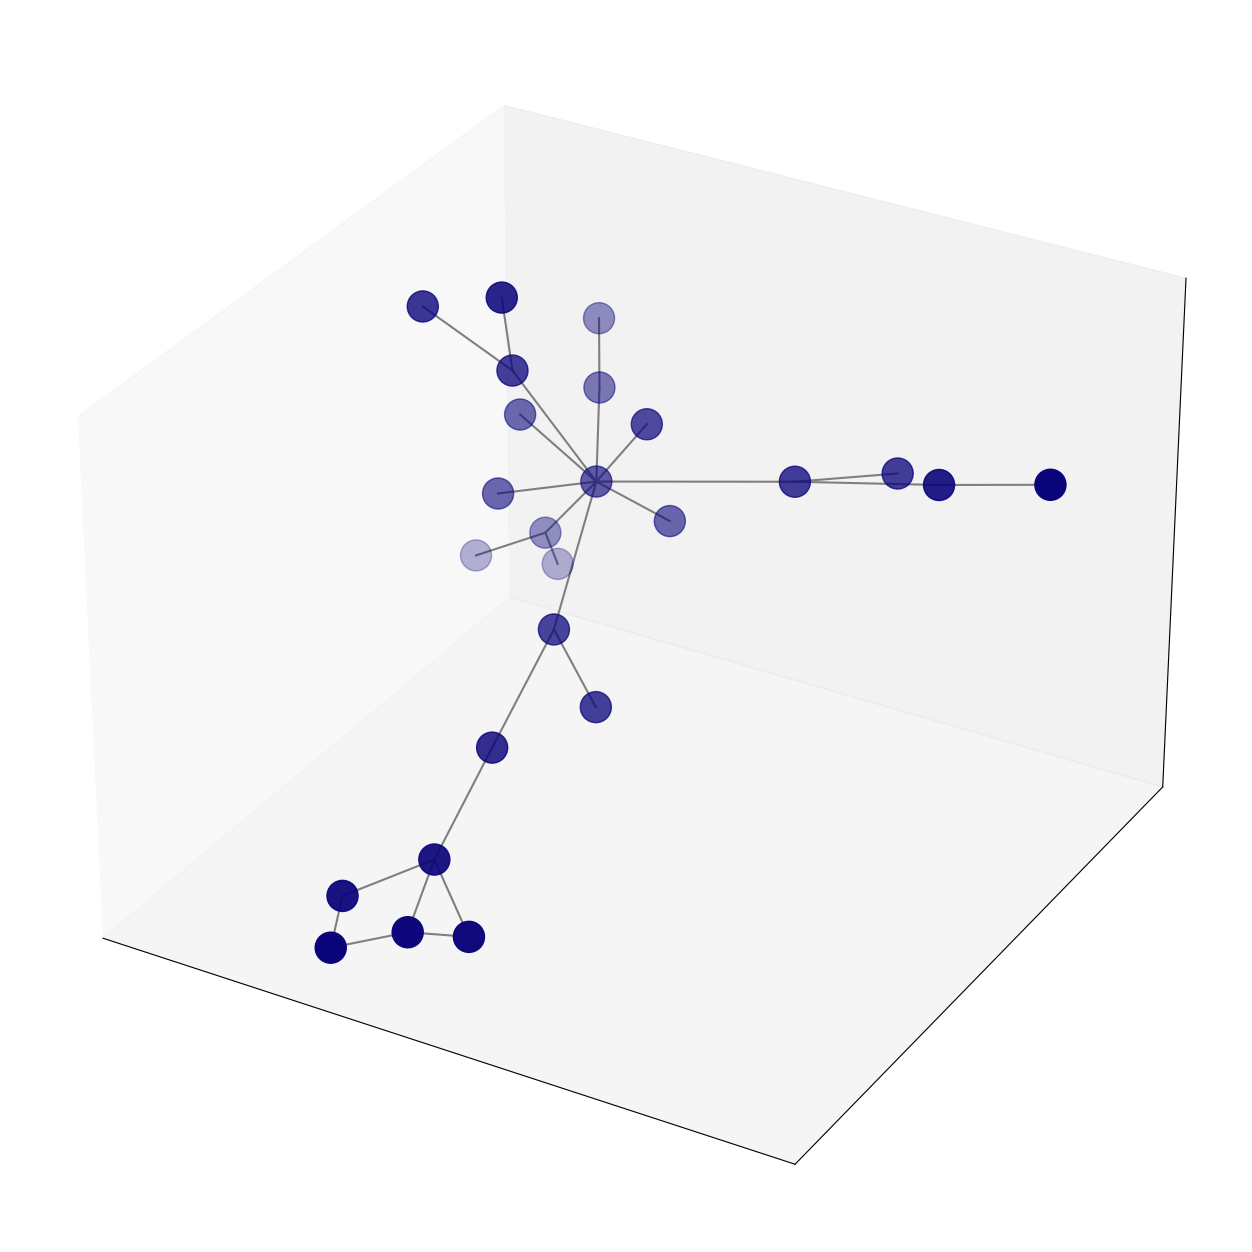

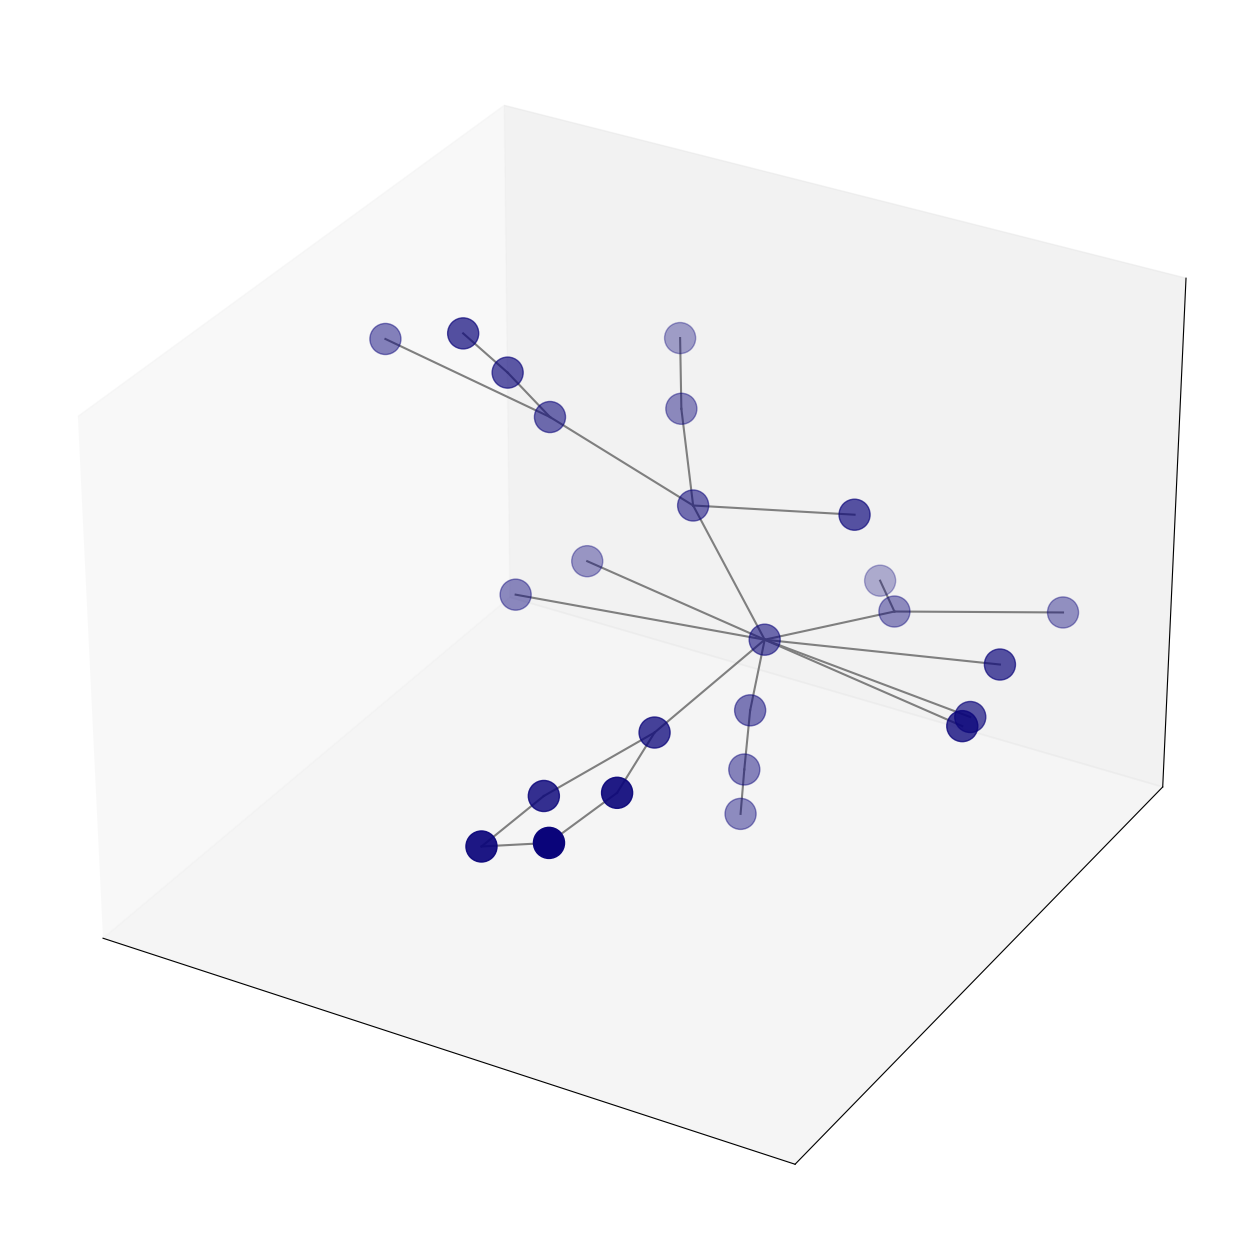

In [15]:
house_motif_graph = dataset[501]
cycle_motif_graph = dataset[0]
visualize(house_motif_graph)
visualize(cycle_motif_graph)

### Load data

In [16]:
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader

data_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
loaded_data = next(iter(data_loader))

train_dataset, val_dataset = train_test_split(dataset, train_size=0.8, stratify=loaded_data.y)
val_dataset, test_dataset = train_test_split(val_dataset, train_size=0.6)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[1600, 10], edge_index=[2, 3262], y=[64], batch=[1600], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[1600, 10], edge_index=[2, 3261], y=[64], batch=[1600], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(x=[1600, 10], edge_index=[2, 3267], y=[64], batch=[1600], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(x=[1600, 10], edge_index=[2, 3265], y=[64], batch=[1600], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(x=[1600, 10], edge_index=[2, 3265], y=[64], batch=[1600], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(x=[1600, 10], edge_index=[2, 3244], y=[64], batch=[1600], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
DataBatch(x=[1600, 10], edge_index=[2, 3253], y=[64], batch=[1600], ptr=[65])

Step 8:
Number of graphs in the current batch: 64
DataBatch(x=[1600, 10], edge_index=[2, 3274], y

### GIN model

In [17]:
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GINConv
from torch_geometric.nn import global_add_pool

class GIN(torch.nn.Module):

    def __init__(self, hidden_dim):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(
                Linear(dataset.num_node_features, hidden_dim),
                BatchNorm1d(hidden_dim),
                ReLU(),
                Linear(hidden_dim, hidden_dim),
                ReLU()
            ))
        self.conv2 = GINConv(
            Sequential(
                Linear(hidden_dim, hidden_dim),
                BatchNorm1d(hidden_dim),
                ReLU(),
                Linear(hidden_dim, hidden_dim),
                ReLU()
            ))
        self.conv3 = GINConv(
            Sequential(
                Linear(hidden_dim, hidden_dim),
                BatchNorm1d(hidden_dim),
                ReLU(),
                Linear(hidden_dim, hidden_dim),
                ReLU()
            ))
        self.linear1 = Linear(3 * hidden_dim, 3 * hidden_dim)
        self.linear2 = Linear(3 * hidden_dim, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.linear1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.linear2(h)

        return h, F.log_softmax(h, dim=1)

In [18]:
gin = GIN(hidden_dim=32)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gin.parameters(), lr=0.01, weight_decay=0.01)
epochs = 50

def accuracy(pred_y, y):
    """Calulate accurac"""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, loader, criterion, optimizer):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        for data in loader:
            optimizer.zero_grad()
            _, out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            total_loss += loss / len(loader)
            acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
            loss.backward()
            optimizer.step()

            # Validation
            if (epoch % 10 == 0):
                val_loss, val_acc = test(model, val_loader, criterion)

        if (epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} '
              f'| Train Acc: {acc*100:>5.2f}% '
              f'| Val Loss: {val_loss:.2f} '
              f'| Val Acc: {val_acc*100:.2f}%')
            
    test_loss, test_acc = test(model, test_loader, criterion)
    print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%')

    return model

def test(model, loader, criterion):
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        _, out = model(data.x, data.edge_index, data.batch)
        loss += criterion(out, data.y) / len(loader)
        acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

    return loss, acc

In [20]:
gin = train(gin, train_loader, criterion, optimizer)

Epoch   0 | Train Loss: 0.69 | Train Acc: 48.68% | Val Loss: 0.69 | Val Acc: 53.24%
Epoch  10 | Train Loss: 0.69 | Train Acc: 48.08% | Val Loss: 0.69 | Val Acc: 52.90%
Epoch  20 | Train Loss: 0.69 | Train Acc: 49.52% | Val Loss: 0.69 | Val Acc: 48.21%
Epoch  30 | Train Loss: 0.69 | Train Acc: 48.68% | Val Loss: 0.69 | Val Acc: 52.34%
Epoch  40 | Train Loss: 0.69 | Train Acc: 47.36% | Val Loss: 0.69 | Val Acc: 52.46%
Test Loss: 0.69 | Test Acc: 42.97%


# On Explainability of Graph Neural Networks via Subgraph Explorations

https://paperswithcode.com/paper/on-explainability-of-graph-neural-networks

In [24]:
import torch
from torch_geometric.datasets import BA2MotifDataset

dataset = BA2MotifDataset(root='data/BA2MotifDataset')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: BA2MotifDataset(1000):
Number of graphs: 1000
Number of features: 10
Number of classes: 2

Data(x=[25, 10], edge_index=[2, 50], y=[1])
Number of nodes: 25
Number of edges: 50
Average node degree: 2.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [25]:
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader

data_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

### GCN model from the article

https://github.com/divelab/DIG/tree/main/dig/xgraph/SubgraphX

In [21]:
from torch_geometric.nn.glob import global_mean_pool
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.conv import GCNConv

# GCN
class GCNNet(nn.Module):
    def __init__(self, input_dim, output_dim, device):
        super(GCNNet, self).__init__()
        self.latent_dim = [20, 20, 20]
        self.mlp_hidden = []
        self.emb_normlize = True
        self.device = device
        self.num_gnn_layers = len(self.latent_dim)
        self.num_mlp_layers = len(self.mlp_hidden) + 1
        self.dense_dim = self.latent_dim[-1]
        self.readout_layers = [global_mean_pool]
        mlp_hidden = []

        self.gnn_layers = nn.ModuleList()
        self.gnn_layers.append(GCNConv(input_dim, self.latent_dim[0], normalize=False))
        for i in range(1, self.num_gnn_layers):
            self.gnn_layers.append(GCNConv(self.latent_dim[i - 1], self.latent_dim[i], normalize=False))
        self.gnn_non_linear = nn.ReLU()

        self.mlps = nn.ModuleList()
        if self.num_mlp_layers > 1:
            self.mlps.append(nn.Linear(self.dense_dim * len(self.readout_layers),
                                       mlp_hidden[0]))
            for i in range(1, self.num_mlp_layers-1):
                self.mlps.append(nn.Linear(self.mlp_hidden[i-1], self.mlp_hidden[1]))
            self.mlps.append(nn.Linear(self.mlp_hidden[-1], output_dim))
        else:
            self.mlps.append(nn.Linear(self.dense_dim * len(self.readout_layers),
                                       output_dim))
        self.dropout = nn.Dropout(0.5)
        self.Softmax = nn.Softmax(dim=-1)
        self.mlp_non_linear = nn.ELU()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        for i in range(self.num_gnn_layers):
            if not self.gnn_layers[i].normalize:
                edge_weight = torch.ones(edge_index.shape[1]).to(self.device)
                x = self.gnn_layers[i](x, edge_index, edge_weight)
            else:
                x = self.gnn_layers[i](x, edge_index)
            if self.emb_normlize:
                x = F.normalize(x, p=2, dim=-1)
            x = self.gnn_non_linear(x)
        emb = x
        pooled = []
        for readout in self.readout_layers:
            pooled.append(readout(emb, batch))
        x = torch.cat(pooled, dim=-1)

        for i in range(self.num_mlp_layers - 1):
            x = self.mlps[i](x)
            x = self.mlp_non_linear(x)
            x = self.dropout(x)

        logits = self.mlps[-1](x)
        probs = self.Softmax(logits)
        return logits, probs, emb

### Load GCN model

In [22]:
import numpy as np
gcn_model = GCNNet(10, 2, 'cpu')
loaded_state = torch.load('gcn_best.pth')['net']
loaded_state["gnn_layers.0.lin.weight"] = loaded_state["model.gnn_layers.0.weight"].T
loaded_state["gnn_layers.0.bias"] = loaded_state["model.gnn_layers.0.bias"]
loaded_state["gnn_layers.1.lin.weight"] = loaded_state["model.gnn_layers.1.weight"].T
loaded_state["gnn_layers.1.bias"] = loaded_state["model.gnn_layers.1.bias"]
loaded_state["gnn_layers.2.lin.weight"] = loaded_state["model.gnn_layers.2.weight"].T
loaded_state["gnn_layers.2.bias"] = loaded_state["model.gnn_layers.2.bias"]
loaded_state["mlps.0.weight"] = loaded_state["model.mlps.0.weight"]
loaded_state["mlps.0.bias"] = loaded_state["model.mlps.0.bias"]
del loaded_state["model.gnn_layers.0.weight"]
del loaded_state["model.gnn_layers.0.bias"]
del loaded_state["model.gnn_layers.1.weight"]
del loaded_state["model.gnn_layers.1.bias"]
del loaded_state["model.gnn_layers.2.weight"]
del loaded_state["model.gnn_layers.2.bias"]
del loaded_state["model.mlps.0.weight"]
del loaded_state["model.mlps.0.bias"]
gcn_model.load_state_dict(loaded_state)

<All keys matched successfully>

### Test accueracy

In [26]:
def accuracy(pred_y, y):
    """Calulate accurac"""
    return ((pred_y == y).sum() / len(y)).item()

def test(model, loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    loss = 0
    acc = 0

    for data in loader:
        logits, probs, emb = model(data)
        loss += criterion(probs, data.y) / len(loader)
        acc += accuracy(probs.argmax(dim=1), data.y) / len(loader)

    return loss, acc

test(gcn_model, data_loader)

(tensor(0.4879, grad_fn=<AddBackward0>), 0.9789999723434448)

Accuracy on  the whole BA-2Motifs dataset: 97.9%